In [1]:
# import all tools needed
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt

# for plotting consistently with abu_profile
from nugridpy import utils as u

# use h5py to read and write h5 file
import h5py

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# read in the 2M kippenhahn diagram
star2 = ms.star_log(mass=2.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 



<IPython.core.display.Javascript object>


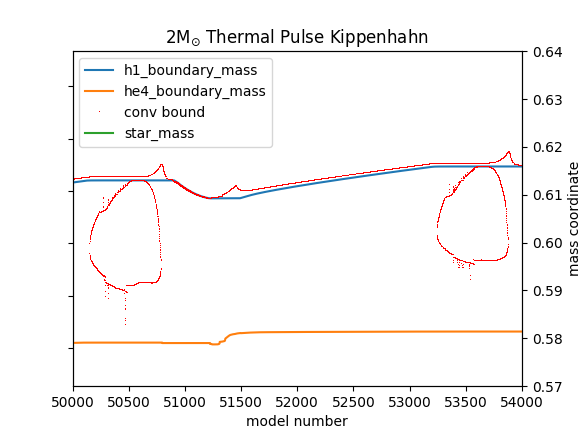

In [10]:
fig = plt.figure(1)
star2.kippenhahn_CO(1,'model')
fig.set_size_inches(5.8,4.35)
# limits to view
plt.xlim([50000,54000])
plt.ylim([0.57,0.64])

# get all axes objects
axes1, axes2 = fig.get_axes()

# turn off axes1 (CO ratio)
axes1.get_legend().remove()
axes1.get_lines().pop(0).remove()
axes1.set_ylabel('')
axes1.set_yticklabels([])

# turn on title
axes2.set_title(r'2M$_{\odot}$ Thermal Pulse Kippenhahn')

# save the figure
fig.savefig('2M Kippenhahn.png')

In [15]:
# function to find the maximum extent of convection zone as well as the average extent
def avg_mass_bounds(star,model_range):
    # just need the star objects, and the model range that the convection zone is contained in

    # get the mass ranges of convection boundary
    star_mass = star.get('star_mass')[model_range[0]:model_range[1]]
    mix_low = star.get('mx2_bot')[model_range[0]:model_range[1]]
    mix_high = star.get('mx2_top')[model_range[0]:model_range[1]]
    
    # find where they are zero or not
    convection_bounds = []
    for i in range(len(star_mass) - 1):
        
        # make sure that there is convection and that the next element doesnt stop
        if mix_low[i] >= 1e-9 and mix_low[i+1] >= 1e-9:
            convection_bounds.append(i)
            
    # slice the arrays to the appropriate size
    star_mass = star_mass[convection_bounds[0]:(convection_bounds[-1] + 1)]
    mix_low = mix_low[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    mix_high = mix_high[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    
    # make sure that if there
    
    # return the max convection bounds as well as average AND new model range
    max_bounds = [min(mix_low),max(mix_high)]
    avg_bounds = [np.mean(mix_low),np.mean(mix_high)]
    model_range = [model_range[0] + convection_bounds[0], model_range[0] + convection_bounds[-1]]
    
    return max_bounds, avg_bounds, model_range

In [20]:
# read in the data
data = np.genfromtxt('/user/david/github/Astr501/David Project/Mg25 Activation/2M_Average.txt',delimiter=',',comments='#',unpack=True)

# grab the neutron density, mass, and temperature
models = data[0]
temperature = data[2]
neutron_d = data[3]

# convert to number density
neutron_mass = 1.674929e-27 * 1e3
neutron_d = neutron_d / neutron_mass

max_bounds, avg_bounds, model_range = avg_mass_bounds(star2,[int(models[0]),int(models[-1])])

In [27]:
ax1.legend?

<IPython.core.display.Javascript object>


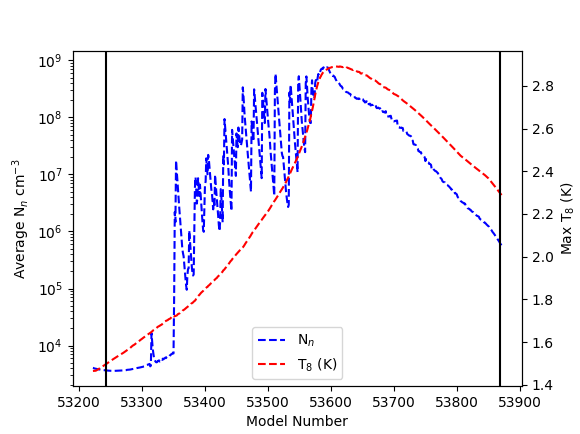

In [31]:
# plot
fig = plt.figure(2)
fig.set_size_inches(5.8,4.35)

# get axis
ax1 = fig.add_subplot(111)

# plot
lns1 = ax1.semilogy(models,neutron_d,'b--',label=r'N$_{n}$')
ax1.set_ylabel(r'Average N$_{n}$ cm$^{-3}$')
ax1.set_xlabel('Model Number')

# second axis
ax2 = ax1.twinx()

# plot
lns2 = ax2.plot(models,temperature / 1e8,'r--',label=r'T$_{8}$ (K)')
ax2.set_ylabel('Max T$_{8}$ (K)')

# add axes lines together for legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=8)

# vertical lines for start and end of convection
ax2.axvline(model_range[0],color='k',linestyle='-')
ax2.axvline(model_range[1],color='k',linestyle='-')

In [ ]:
# grab the 